# sai: spooky author identification
## analysis 3: random forest

## discussion
In the previous code, the author identification analysis was performed with Naive Bayes Classification and Logistic Regression.  This used CountVectorizer to identify the author based on the text prose and split the training set into two areas: split and vectorize, or vectorize and split.  The later proved productive; therefore, this experiment will use random forests with hyperparameter tuning with CountVectorizer to obtain better predictions.  


## code
### preliminaries
Import libraries and modules.  Read csv file.  And show what's in it!

In [140]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn.cross_validation import train_test_split             # cross-validation
from sklearn.feature_extraction.text import CountVectorizer       # vectorizer
from sklearn.ensemble import RandomForestClassifier               # classifier
from sklearn.ensemble import ExtraTreesClassifier                 # classifier
from sklearn.model_selection import GridSearchCV                  # parameter tuning
from sklearn.model_selection import RandomizedSearchCV            # parameter tuning
from sklearn.pipeline import Pipeline                             # pipeline
from sklearn import metrics                                       # metrics

# other modules
from stop_words import get_stop_words
from scipy.stats import randint as sp_randint
import string
from pprint import pprint


# Read training texts: texts
texts = pd.read_csv('train.csv')
texts.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### simple run
This will use CountVectorizer, TfidfVectorizer, and Random Forest Classifier on the training set.

#### feature selection

In [3]:
# choose X and y
X = texts.text
y = texts.author

#### vectorize

In [4]:
# vectorize 
vect = CountVectorizer()
vect.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [5]:
# document-term matrix
X_dtm = vect.transform(X)

#### split

In [7]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [8]:
# transform training case
X_train_dtm = vect.transform(X_train)

# transform test case
X_test_dtm = vect.transform(X_test)

#### fit and predict

In [9]:
# random forest classifier; please note this is NOT including parameters
rf = RandomForestClassifier()

In [10]:
# fit the model
%time rf.fit(X_train_dtm, y_train)

CPU times: user 5 s, sys: 21.5 ms, total: 5.02 s
Wall time: 5.02 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [11]:
# predict with training class
y_train_pred = rf.predict(X_train_dtm)

In [12]:
# predict with testing class
y_test_pred = rf.predict(X_test_dtm)

In [13]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = rf.predict_proba(X_test_dtm)

#### evaluate

In [14]:
# accuracy score, train
metrics.accuracy_score(y_train, y_train_pred)

0.98923998910378641

In [15]:
# accuracy score, test
metrics.accuracy_score(y_test, y_test_pred)

0.61879468845760977

In [16]:
# confusion matrix, train
metrics.confusion_matrix(y_train, y_train_pred)

array([[5935,    5,    9],
       [  66, 4143,    3],
       [  67,    8, 4448]])

In [17]:
# print confusion matrix
metrics.confusion_matrix(y_test, y_test_pred)

array([[1613,  148,  190],
       [ 626,  676,  121],
       [ 608,  173,  740]])

In [18]:
# classification report, train
print(metrics.classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        EAP       0.98      1.00      0.99      5949
        HPL       1.00      0.98      0.99      4212
        MWS       1.00      0.98      0.99      4523

avg / total       0.99      0.99      0.99     14684



In [19]:
# classification report, test
print(metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        EAP       0.57      0.83      0.67      1951
        HPL       0.68      0.48      0.56      1423
        MWS       0.70      0.49      0.58      1521

avg / total       0.64      0.62      0.61      4895



### updated parameters 
This will use the code from sci-kit learn developers to estimate the OOB (out of bag) error and the best feature handler for this dataset.  Here, the n_estimators is 100; n_estimators  

In [181]:
model =  RandomForestClassifier(n_estimators = 100, oob_score = True, warm_start = True)

In [182]:
%time model.fit(X_train_dtm, y_train)
y_train_pred = model.predict(X_train_dtm)

CPU times: user 53.7 s, sys: 314 ms, total: 54 s
Wall time: 54.1 s


In [183]:
print(metrics.confusion_matrix(y_train, y_train_pred))

[[5925    0    0]
 [   0 4226    0]
 [   0    0 4533]]


In [184]:
print(metrics.classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        EAP       1.00      1.00      1.00      5925
        HPL       1.00      1.00      1.00      4226
        MWS       1.00      1.00      1.00      4533

avg / total       1.00      1.00      1.00     14684



In [185]:
y_test_pred = model.predict(X_test_dtm)

In [186]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.700102145046


In [187]:
print(metrics.confusion_matrix(y_test, y_test_pred))

[[1731   91  153]
 [ 566  761   82]
 [ 491   85  935]]


In [28]:
print(metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        EAP       0.61      0.90      0.73      1951
        HPL       0.81      0.52      0.63      1423
        MWS       0.80      0.60      0.68      1521

avg / total       0.73      0.69      0.69      4895



## hyperparameter tuning
### discussion
Random Forests may be the best estimator; however, tuning them is not!  Below is a simple RandomForestClassifier model:

`
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
`


There are five different parameters to evaluate for a better score.  And with computational time an issue, it is best to break down each parameter and promote one with the best estimate parameters.  

* max_features=`['sqrt','auto','log2']`
* criterion=`['gini','entropy']`
* n_estimators=`[50, 100, 150, 200]`
* min_samples_leaf=`[50,100,150]`

Other parameters will make it easy to train; this includes:

* random_state=42
* oob_score=True 
* warm_start=True (use previous build to build new set)


### 1 - `n_estimators` 
This will use the code from sci-kit learn developers to estimate the OOB (out of bag) error and the best feature handler for this dataset.  Here, the n_estimators is 10; n_estimators will increase every 10 steps per iteration so the final n will be 410 (40 * 10 + 10).  

In [51]:
errors = []
growing_rf = RandomForestClassifier(n_estimators=10, 
                                    n_jobs=-1,  
                                    warm_start=True, 
                                    random_state=1514)

for i in range(40):
    growing_rf.fit(X_train_dtm, y_train)
    errors.append(metrics.log_loss(y_test, growing_rf.predict_proba(X_test_dtm)))
    growing_rf.n_estimators += 10

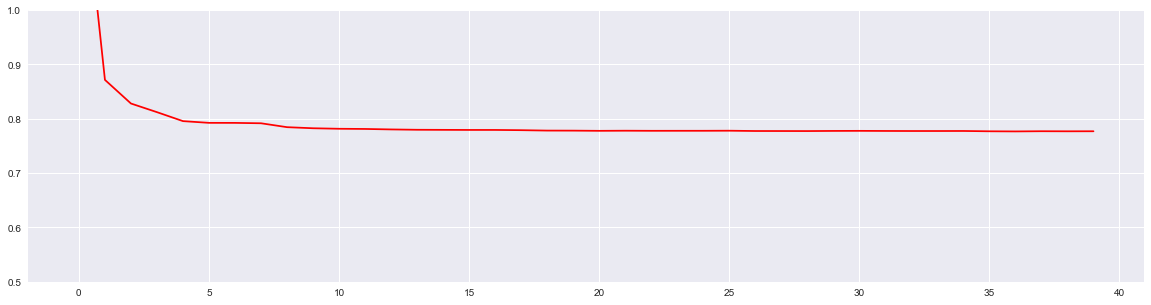

In [189]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(errors, '-r')
_ = plt.ylim([0.5, 1.0])

So far, within the first 5 iterations (where n_estimators = 10 to 60), the error goes down significantly but afterwards, it hovers around 0.77-0.79.  So it steadied.

### 2 - `n_estimators`  +  `max_features`
This will use the same code but will also use `max_features`.  This comes from the following link: http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py.  This is essential to see how one feature does when another feature gets tweaked.  And it will determine a better choice for `max_features`.  

In [137]:
RANDOM_STATE = 123

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, 
                               oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, 
                               max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, 
                               max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

In [135]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

for label, clf in ensemble_clfs:
    for i in range(10):
        clf.fit(X_train_dtm, y_train)
        
        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        log_loss_error = metrics.log_loss(y_test, clf.predict_proba(X_test_dtm))
        
        # Enter error rate details
        error_rate[label].append((i, clf.n_estimators, log_loss_error))
        
        # Update n_estimators 
        clf.n_estimators += 10

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were us

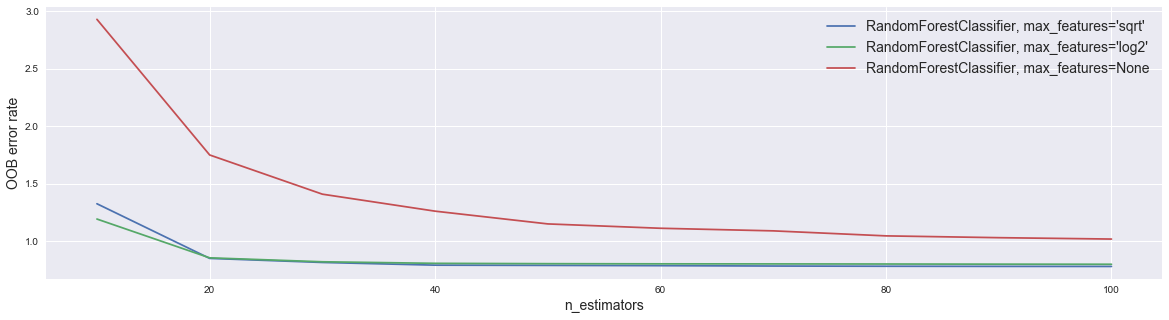

In [190]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(20,5))

for label, clf_err in error_rate.items():
    xs, ys, zs = zip(*clf_err)
    plt.plot(ys, zs, label=label)

plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("OOB error rate", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

Like above, the first five estimators start with high errors.  However, the error goes down.  However, with NO maximum features, it steadied around 0.38-0.39.  With the other two maximum features, the 'sqrt' random forest had a slightly higher error than the 'log2' random forest but the 'log2' overtook it, having a smaller error over the long term.  This would continue for another 50 n_estimators.  

Working with n_estimators, the log2 random forest does well with this training set than the sqrt random forest and especially the random forest where there are no maximum features.  Even in a quick grid search, `sqrt` did the best with the training set although the best values were not present.  

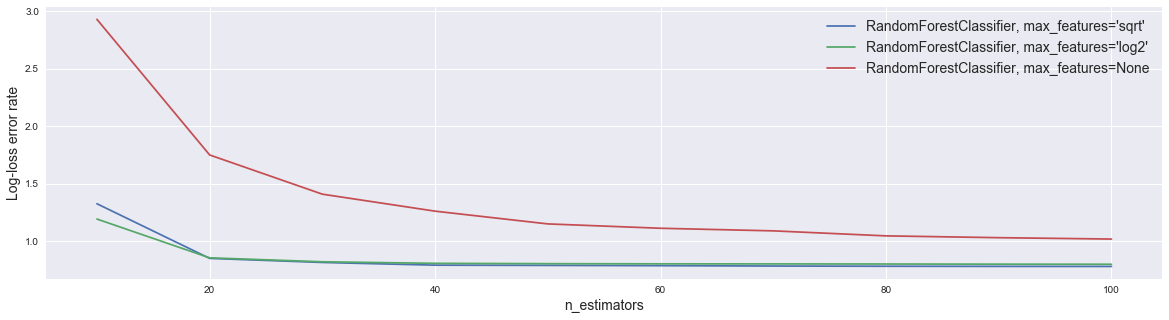

In [193]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(20,5))

for label, clf_err in error_rate.items():
    xs, ys, zs  = zip(*clf_err)
    plt.plot(ys, zs, label=label)

plt.xlabel("n_estimators", fontsize=14)
plt.ylabel("Log-loss error rate", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

Using the same evaluation metric, log_loss, the 'None' random forest has the same curvature as above.  However, the two have steady log-loss error rates below 0.80.  'log2', which did well in the OOB error curve, had a larger error by 0.01-0.02 against 'sqrt', as to why the pipeline preferred 'sqrt' as the best.  But also, it doesn't seem that one parameter is influencing the other.  While this is a simple choice, it will remain the same.  

### 3 - `min_samples_leaf`
This will now test the minimum sample leafs using the information obtained above.  Seeing that the n_estimators perform well after 50 and that the 'log2' random forest and the 'sqrt' random forest did better than having no maximum features, it would be best to continue on this route.  Hypothetically if having 15 possibilities per feature to check, then with n features, it would recur 15 * n, and this is not including cross-validation.  

In [121]:
sample_leaf_options = list(range(1,10))

In [130]:
leaf_error = []

for leaf_size in sample_leaf_options:
    clf = RandomForestClassifier(n_estimators = 100, 
                                oob_score = True, 
                                warm_start = True,
                                n_jobs = -1,
                                random_state = RANDOM_STATE, 
                                max_features = "log2", 
                                min_samples_leaf = leaf_size)
    
    clf.fit(X_train_dtm, y_train)
    
    # OOB and log-loss error
    log_loss_error = metrics.log_loss(y_test, clf.predict_proba(X_test_dtm))
        
    # Enter error rate details
    leaf_error.append((leaf_size, log_loss_error))

In [133]:
leaf_error

[(1, 0.79931193729958327),
 (2, 0.96930408294510673),
 (3, 1.0226134991021902),
 (4, 1.054235881557676),
 (5, 1.0674734695632957),
 (6, 1.0746039938900027),
 (7, 1.0785372570634073),
 (8, 1.0809019475598376),
 (9, 1.0821736081707012)]

The default leaf sample size (= 1) seems to be the best choice.  As the minimal sample increases so does the leaf error (the log-loss error when changing the number).  Also, after the ninth iteration, the error will remain stabilized.  It will still compute but it will stabilize.  Thus the min_samples_leaf is best left alone.

### 4 - Other Tuning Points

In [144]:
# tuning
# pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(binary=True, stop_words=None)),
    ('rf', RandomForestClassifier(oob_score=True, 
                                  random_state=RANDOM_STATE, 
                                  warm_start=True,
                                 bootstrap=True))
])

# parameters (please note too many)
parameters = dict(
    rf__max_features = ['sqrt','log2'],
    rf__criterion = ["gini", "entropy"],
    rf__max_depth = [3, None],
    rf__min_samples_split = sp_randint(2, 11),
    rf__min_samples_leaf =  sp_randint(1, 11),
    rf__n_estimators = [10, 25, 50, 75, 100, 125, 150, 175, 200],
    vect__max_df = (0.5, 0.75, 1.0),
    vect__ngram_range = [(1,1), (1,2), (2,2)]
)

In [145]:
# cv=5 academically proven as best fold, kept n_jobs (jobs running parallel)= 1, output time
rand_search = RandomizedSearchCV(pipeline, 
                           parameters, 
                           n_jobs=1, 
                           cv=5
                )

In [146]:
# fit model for best parameters
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters, depth=2)

%time rand_search.fit(X_train, y_train)

Performing grid search...
pipeline: ['vect', 'rf']
parameters:
{'rf__criterion': ['gini', 'entropy'],
 'rf__max_depth': [3, None],
 'rf__max_features': ['sqrt', 'log2'],
 'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110fd7f98>,
 'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110fd70f0>,
 'rf__n_estimators': [10, 25, 50, 75, 100, 125, 150, 175, 200],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': [(...), (...), (...)]}
CPU times: user 2min 42s, sys: 5.81 s, total: 2min 48s
Wall time: 2min 48s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...estimators=10, n_jobs=1, oob_score=True, random_state=123,
            verbose=0, warm_start=True))]),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'rf__max_features': ['sqrt', 'log2'], 'rf__criterion': ['gini', 'entropy'], 'rf__max_depth': [3, None], 'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110fd70f0>, 'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x110fd7f98>, 'rf__n_estimators': [10, 25, 50, 75, 100, 125, 150, 175, 200], 'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': [(1, 1), (1, 2), (2, 2)

In [147]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.612
Best parameters set:
	rf__criterion: 'gini'
	rf__max_depth: None
	rf__max_features: 'sqrt'
	rf__min_samples_leaf: 1
	rf__min_samples_split: 2
	rf__n_estimators: 10
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


## random search with tuned parameters

In [153]:
# import and instantiate CountVectorizer (with the default parameters)
vect_rf = CountVectorizer(max_df=0.5, 
                          ngram_range=(1,1))

In [154]:
# learn the 'vocabulary' of the training data (occurs in-place)
X_dtm = vect_rf.fit_transform(X)

In [155]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [156]:
# transform 
X_train_dtm = vect_rf.transform(X_train)
X_test_dtm = vect_rf.transform(X_test)

In [168]:
# random forest classifier; please note this is NOT including parameters
rf = RandomForestClassifier(oob_score=True, 
                            warm_start=True,
                            max_features='log2',
                            n_estimators=100
                           )

In [169]:
# fit the model
%time rf.fit(X_train_dtm, y_train)

CPU times: user 53.3 s, sys: 296 ms, total: 53.6 s
Wall time: 53.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=True)

In [170]:
# predict with training class
y_train_pred = rf.predict(X_train_dtm)

In [171]:
# predict with testing class
y_test_pred = rf.predict(X_test_dtm)

In [172]:
# calculate predicted probabilities for X_test_dtm
y_pred_prob = rf.predict_proba(X_test_dtm)

In [173]:
# accuracy score, train
metrics.accuracy_score(y_train, y_train_pred)

1.0

In [174]:
# accuracy score, test
metrics.accuracy_score(y_test, y_test_pred)

0.72053115423901937

In [175]:
# confusion matrix, train
metrics.confusion_matrix(y_train, y_train_pred)

array([[5925,    0,    0],
       [   0, 4226,    0],
       [   0,    0, 4533]])

In [176]:
# print confusion matrix
metrics.confusion_matrix(y_test, y_test_pred)

array([[1840,   25,  110],
       [ 614,  712,   83],
       [ 492,   44,  975]])

In [177]:
# classification report, train
print(metrics.classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        EAP       1.00      1.00      1.00      5925
        HPL       1.00      1.00      1.00      4226
        MWS       1.00      1.00      1.00      4533

avg / total       1.00      1.00      1.00     14684



In [178]:
# classification report, test
print(metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        EAP       0.62      0.93      0.75      1975
        HPL       0.91      0.51      0.65      1409
        MWS       0.83      0.65      0.73      1511

avg / total       0.77      0.72      0.71      4895



### identification and final computations

In [196]:
# calculate predicted probabilities for X_test_dtm
# naive bayes = good classifier but bad something (not produced well-predicted probabilities)
y_pred_prob = rf.predict_proba(X_test_dtm)

In [199]:
exp1_C_lst5 = rf.predict(X_test_dtm)